# Machine learning modeling

baseline 모델로 randomforest를 이용한다.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib.util import find_spec
if find_spec("costa_rican") is None:
    import sys
    sys.path.append('..')

In [3]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

In [4]:
import os
os.chdir(r"/home/skang/Documents/Costa_Rican_Household_Poverty_Level_Prediction/notebooks")

In [5]:
pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('../input/costa-rican-household-poverty-prediction/train.csv')
test = pd.read_csv('../input/costa-rican-household-poverty-prediction/test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [6]:
from costa_rican.utils.feature_engineering import preprocessing_train_test_and_merge, features_v1, split_train_test

In [7]:
data = preprocessing_train_test_and_merge(train, test)
final = features_v1(data)
train_set, test_set, train_labels = split_train_test(final)

Before
There are 85 households where the family members do not all have the same target
After
There are 0 households where the family members do not all have the same target
There are 85 correlated columns to remove.


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [9]:
scorer_params = {
    'score_func': f1_score,
    'greater_is_better': True,
    'average': 'macro'
}

In [10]:
from costa_rican.utils.evaluation import make_custom_scorer

# cross validation을 위한 custom scorer
scorer = make_custom_scorer()

In [11]:
# submission 제출을 위한 base df
submission_base = test[['Id', 'idhogar']].copy()

다른 모델들을 비교할 것이기 때문에 특징들의 크기를 표준화 해준다. 대부분의 앙상블 모델에서는 이러한 작업이 불필요하지만, distance metric에 의존적인 모델을 사용하게 된다면 (KNearest Neighbors or Support vector machine) 이러한 feature scaling 작업이 필요하다.

`Pipeline` 함수를 이용하여 scaling과 결측값 처리를 같이 이어서 해준다.

In [12]:
from costa_rican.utils.training import fill_null_and_scaling

In [13]:
features = list(train_set.columns)
train_set, test_set = fill_null_and_scaling(train_set, test_set)

In [14]:
rf_params = {
    'n_estimators': 100,
    'random_state': 10,
    'n_jobs': -1
    }

In [15]:
from costa_rican.utils.evaluation import CVScore
rf_cv_score = CVScore(RandomForestClassifier, model_params=rf_params, scorer_params=scorer_params)

In [16]:
rf_cv_score.train(train_set, train_labels)

RandomForestClassifier
10 Fold Cross Validation F1 Score = 0.3426 with std = 0.0476


# Feature importance

tree base 모델의 경우 feature importances를 확인할 수 있다. 절대적인 크기가 아닌 상대적인 중요도를 확인해본다.

In [17]:
from costa_rican.utils.training import SklearnWrapper

In [18]:
rf_trainer = SklearnWrapper(RandomForestClassifier, params=rf_params)

rf_trainer.train(train_set, train_labels)
# Feature importances into a dataframe
feature_importances = rf_trainer.get_feature_importances()
feature_importances.head()

,feature,importance
0,hacdor,0.000701
1,hacapo,0.000476
2,v14a,0.000261
3,refrig,0.001715
4,paredblolad,0.006107


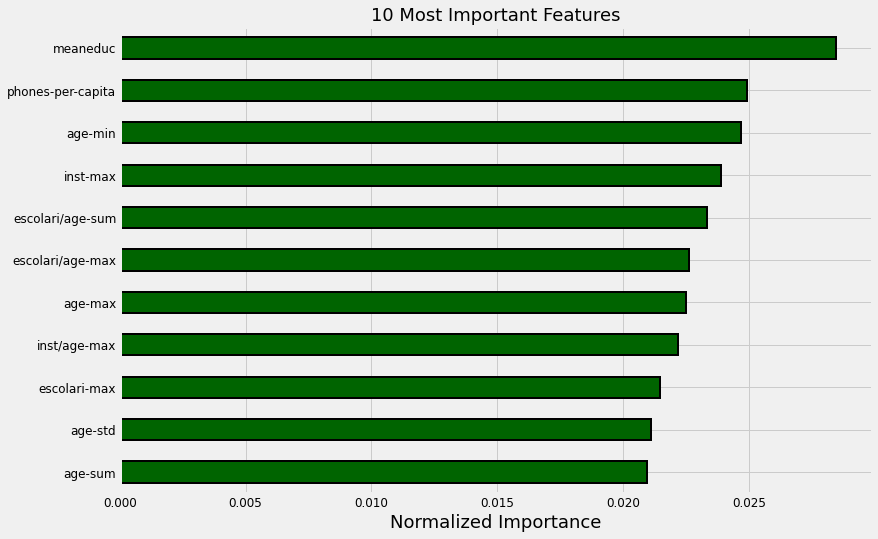

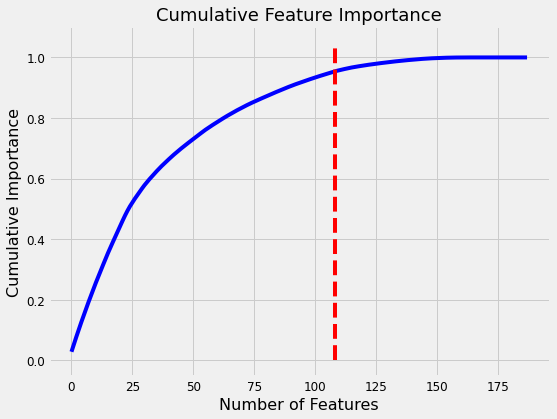

108 features required for 95% of cumulative importance.


In [19]:
from costa_rican.utils.visualization import PlotFeatureImportances

plot_feature_importances = PlotFeatureImportances()
df = plot_feature_importances(feature_importances, threshold=0.95)

In [20]:
df.head()

,feature,importance,importance_normalized,cumulative_importance
0,meaneduc,0.028454,0.028454,0.028454
1,phones-per-capita,0.024930,0.024930,0.053384
2,age-min,0.024681,0.024681,0.078065
3,inst-max,0.023913,0.023913,0.101978
4,escolari/age-sum,0.023342,0.023342,0.125319


### Education reigns supreme

In [21]:
from costa_rican.utils.visualization import KdePlotByTargetAndColumns

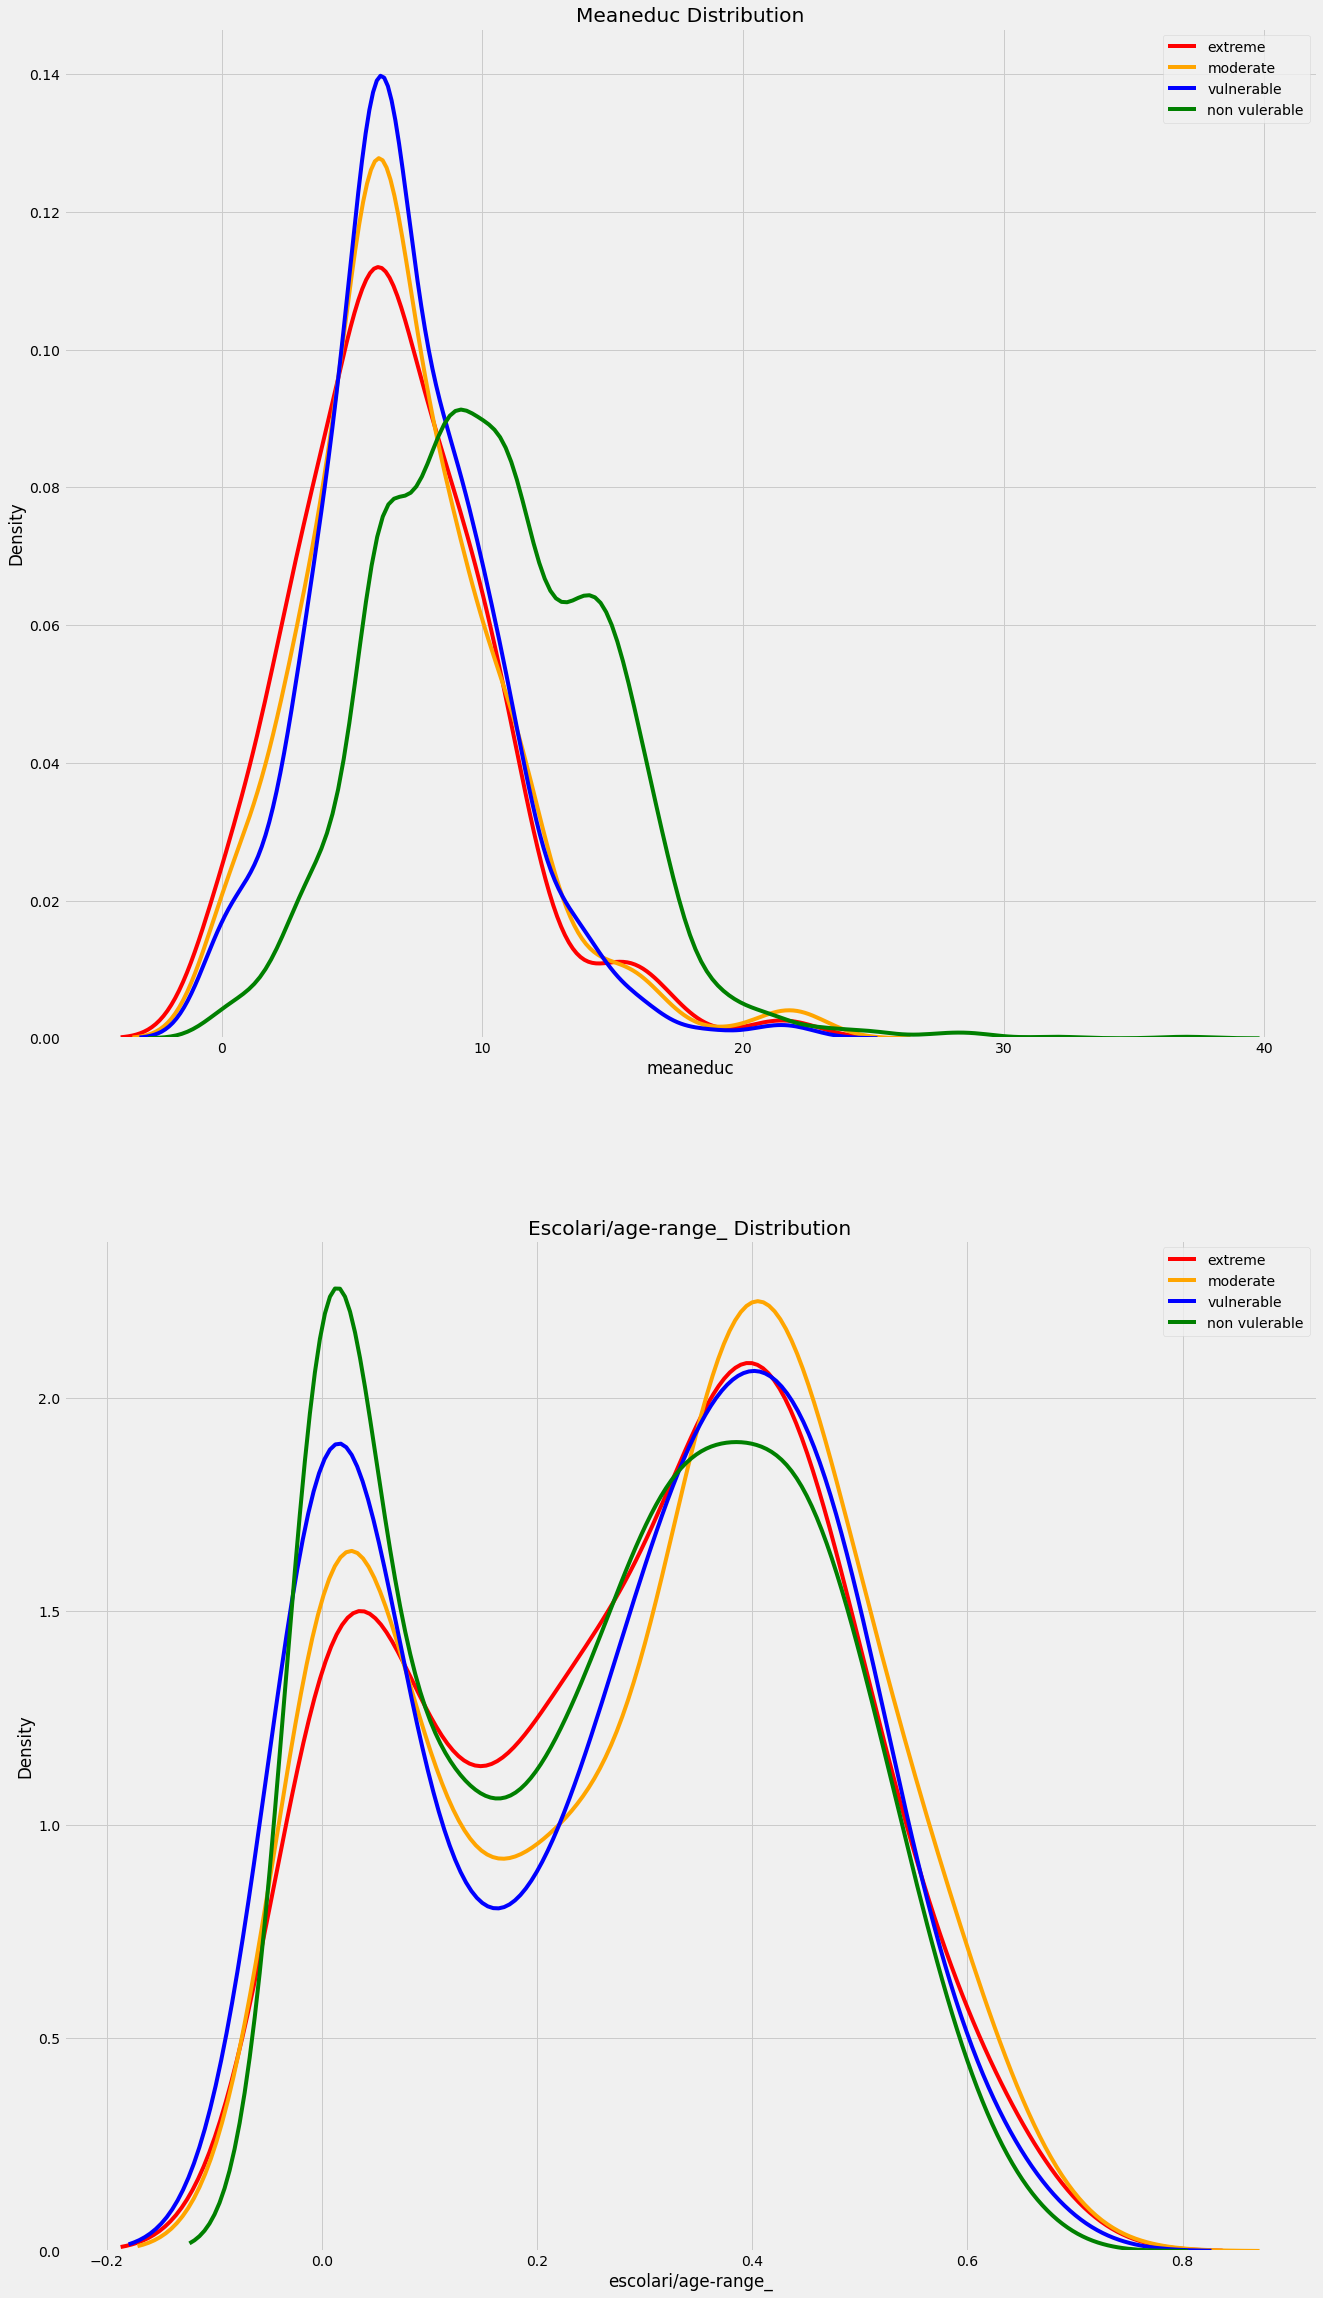

In [22]:
kde_target = KdePlotByTargetAndColumns(final)
kde_target(['meaneduc', 'escolari/age-range_'])

# Model Selection

In [23]:
# Model imports
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [24]:
import warnings 
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

from costa_rican.utils.evaluation import cv_model

In [25]:
model_results = cv_model(train_set, train_labels, LinearSVC(), scorer, 'LSVC', model_results)

10 Fold CV Score: 0.27743 with std: 0.04275


In [26]:
model_results = cv_model(train_set, train_labels, 
                         GaussianNB(), scorer, 'GNB', model_results)

10 Fold CV Score: 0.18958 with std: 0.04294


In [27]:
model_results = cv_model(train_set, train_labels, 
                         MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32)),
                          scorer, 'MLP', model_results)

10 Fold CV Score: 0.30494 with std: 0.0492


In [28]:
model_results = cv_model(train_set, train_labels, 
                          LinearDiscriminantAnalysis(), 
                           scorer, 'LDA', model_results)

10 Fold CV Score: 0.31184 with std: 0.05927


In [29]:
model_results = cv_model(train_set, train_labels, 
                         RidgeClassifierCV(), scorer, 'RIDGE', model_results)

10 Fold CV Score: 0.27858 with std: 0.03135


In [30]:
for n in [5, 10, 20]:
    print(f'\nKNN with {n} neighbors\n')
    model_results = cv_model(train_set, train_labels, 
                             KNeighborsClassifier(n_neighbors = n),
                              scorer, f'knn-{n}', model_results)


KNN with 5 neighbors

10 Fold CV Score: 0.31844 with std: 0.02311

KNN with 10 neighbors

10 Fold CV Score: 0.29539 with std: 0.03998

KNN with 20 neighbors

10 Fold CV Score: 0.27013 with std: 0.02263


In [31]:
from sklearn.ensemble import ExtraTreesClassifier

model_results = cv_model(train_set, train_labels, 
                         ExtraTreesClassifier(n_estimators = 100, random_state = 10),
                          scorer, 'EXT', model_results)

10 Fold CV Score: 0.32199 with std: 0.04616


## Comparing model performance

In [32]:
model_results = cv_model(train_set, train_labels,
                        RandomForestClassifier(100, random_state=10),
                        scorer, 'RF', model_results)

10 Fold CV Score: 0.34933 with std: 0.04931


In [33]:
model_results

,model,cv_mean,cv_std
0,LSVC,0.277429,0.042749
1,GNB,0.189575,0.042944
2,MLP,0.304936,0.0492
3,LDA,0.311844,0.059267
4,RIDGE,0.27858,0.031348
5,knn-5,0.318445,0.023109
6,knn-10,0.29539,0.039983
7,knn-20,0.270131,0.022626
8,EXT,0.321993,0.04616
9,RF,0.349331,0.049311


In [34]:
from costa_rican.utils.visualization import CVBarPlot

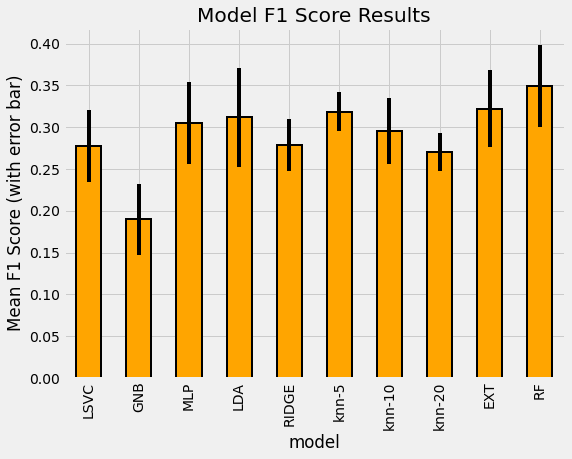

In [35]:
bar_plot_error_bar = CVBarPlot()
bar_plot_error_bar(model_results)

In [36]:
model_results.reset_index(inplace = True)

# Making a submission

In [37]:
test_ids = list(final.loc[final['Target'].isnull(), 'idhogar'])

In [38]:
len(test_ids)

7334

In [39]:
from costa_rican.utils.inference import submit

In [40]:
rf_submission = submit(RandomForestClassifier(n_estimators = 100, 
                                              random_state=10, n_jobs = -1), 
                        train_set, train_labels, test_set, test_ids, submission_base)

rf_submission.to_csv('rf_submission.csv', index = False)

# Feature selection

높은 correlation을 갖는 인자들을 제거한다.

In [41]:
from costa_rican.utils.feature_engineering import drop_high_pcorr_features

train_set = drop_high_pcorr_features(train_set, features)
train_set.shape

There are 2 correlated columns to remove.


(2973, 186)

In [42]:
from costa_rican.utils.feature_engineering import align_train_test

In [43]:
train_set, test_set, features = align_train_test(train_set, test_set, features)

## Recursive feature elimination with randomforest

n_features
74


/home/skang/Documents/Costa_Rican_Household_Poverty_Level_Prediction/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


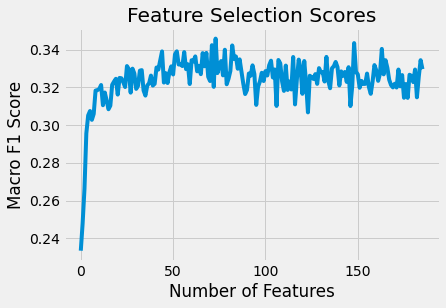

In [44]:
from sklearn.feature_selection import RFECV
from costa_rican.utils.evaluation import make_custom_scorer, RFEWithCV

# Create a model for feature selection
estimator = RandomForestClassifier(random_state = 10, n_estimators = 100,  n_jobs = -1)

scorer = make_custom_scorer()
# Create the object
rfecv = RFEWithCV(estimator, scorer)
selector = rfecv(train_set, train_labels)

rank는 특징의 중요도를 나타낸다. 특징들은 같은 rank를 가질 수 있고, rank == 1인 인자들만 유지된다.

In [45]:
rankings = pd.DataFrame({'feature': list(train_set.columns), 'rank': list(selector.ranking_)}).sort_values('rank')
rankings.head(10)

,feature,rank
101,female-std,1
54,area1,1
83,roof,1
84,floor,1
85,walls+roof+floor,1
105,estadocivil1-sum,1
86,warning,1
48,lugar1,1
87,bonus,1
121,estadocivil7-sum,1


In [46]:
len(rankings[rankings['rank'] == 1])

74

In [47]:
train_selected = selector.transform(train_set)
test_selected = selector.transform(test_set)

In [48]:
# Convert back to dataframe
selected_features = train_set.columns[np.where(selector.ranking_==1)]
train_selected = pd.DataFrame(train_selected, columns = selected_features)
test_selected = pd.DataFrame(test_selected, columns = selected_features)

In [49]:
model_results = cv_model(train_selected, train_labels, RandomForestClassifier(random_state = 10, n_estimators = 100,  n_jobs = -1), scorer, 'RF-SEL', model_results)

10 Fold CV Score: 0.35686 with std: 0.04439


In [50]:
model_results

,index,model,cv_mean,cv_std
0,0.0,LSVC,0.277429,0.042749
1,1.0,GNB,0.189575,0.042944
2,2.0,MLP,0.304936,0.0492
3,3.0,LDA,0.311844,0.059267
4,4.0,RIDGE,0.27858,0.031348
5,5.0,knn-5,0.318445,0.023109
6,6.0,knn-10,0.29539,0.039983
7,7.0,knn-20,0.270131,0.022626
8,8.0,EXT,0.321993,0.04616
9,9.0,RF,0.349331,0.049311


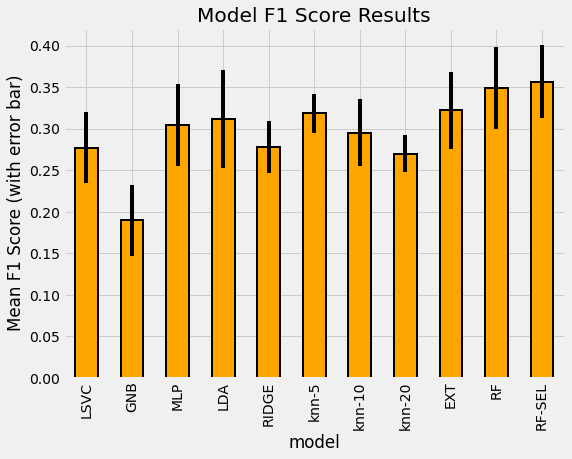

In [51]:
bar_plot_error_bar(model_results)

성능이 조금 상승한 것을 확인할 수 있다.

# Upgrading our model: Gradient boosting machine

In [52]:
from costa_rican.utils.evaluation import macro_f1_score, model_gbm

In [53]:
%%capture --no-display
predictions, gbm_fi = model_gbm(train_set, train_labels, test_set, test_ids, submission_base.copy(), return_preds=True)

'None'

'Fold 1, Validation Score: 0.39543, Estimators Trained: None'

/home/skang/Documents/Costa_Rican_Household_Poverty_Level_Prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/skang/Documents/Costa_Rican_Household_Poverty_Level_Prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/skang/Documents/Costa_Rican_Household_Poverty_Level_Prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/skang/Documents/Costa_Rican_Household_Poverty_Level_Prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/skang/Documents/Costa_Rican_Household_Poverty_Level_Prediction/venv/li

'None'

'Fold 2, Validation Score: 0.37603, Estimators Trained: None'

'None'

'Fold 3, Validation Score: 0.39692, Estimators Trained: None'

'None'

'Fold 4, Validation Score: 0.41671, Estimators Trained: None'

'None'

'Fold 5, Validation Score: 0.42451, Estimators Trained: None'

'5 cross validation score: 0.40192 with std: 0.01713.'

In [54]:
predictions.head()

,1,2,3,4,idhogar,fold,Target,confidence
0,0.000188,0.000626,0.002857,0.996330,72958b30c,1,4,0.996330
1,0.053386,0.002122,0.001838,0.942654,5b598fbc9,1,4,0.942654
2,0.015956,0.238509,0.045525,0.700010,1e2fc704e,1,4,0.700010
3,0.000714,0.000120,0.000097,0.999069,8ee7365a8,1,4,0.999069
4,0.005986,0.012232,0.007554,0.974228,ff69a6fc8,1,4,0.974228


In [55]:
from costa_rican.utils.visualization import FaceGridEachFold

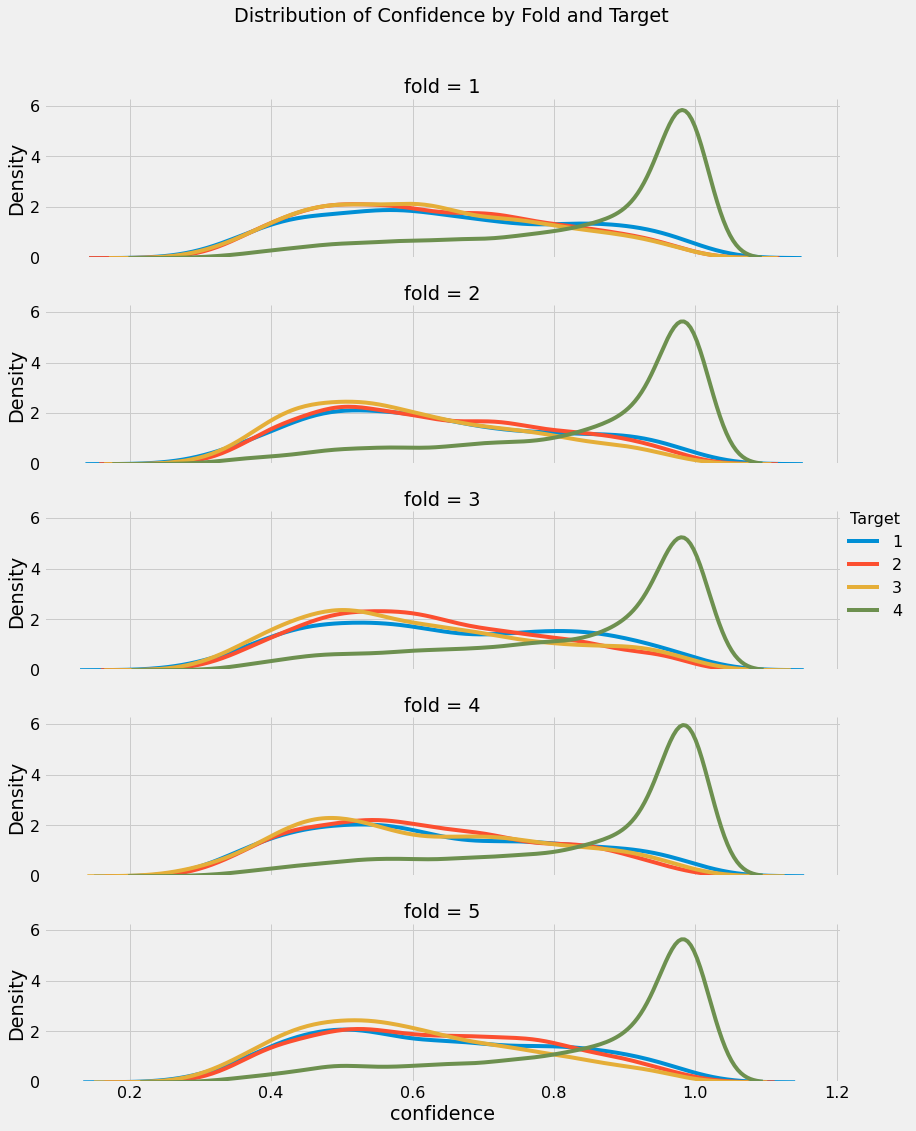

In [56]:
fold_distribution = FaceGridEachFold()
fold_distribution(predictions)

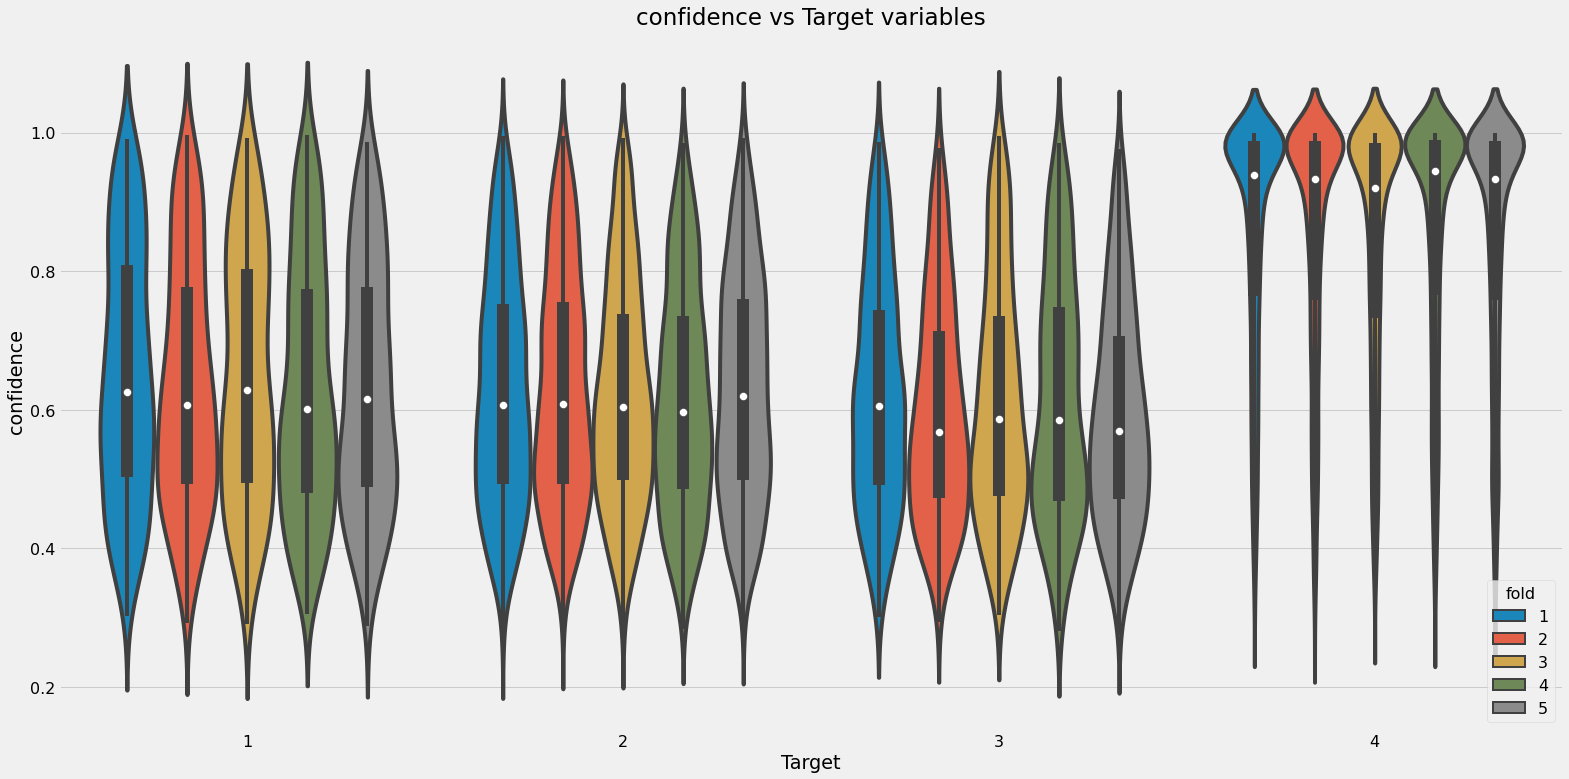

In [57]:
from costa_rican.utils.visualization import ViolinByTarget
violin_by_fold = ViolinByTarget(figsize=(24, 12))
violin_by_fold(x="Target", y="confidence", hue='fold', data=predictions)

imbalance 데이터에 대한 안좋은 결과를 보이는 것을 확인할 수 있다.     
추후 결과를 보고 어디서 모델이 잘못되었는지 판단한다.

fold에 대해 평균한 결과는 아래와 같다.

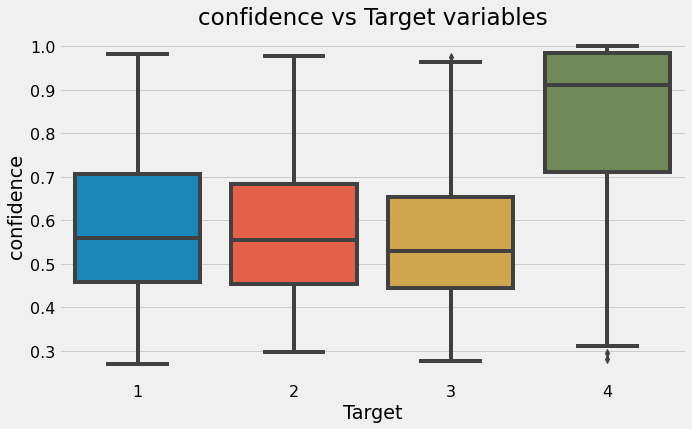

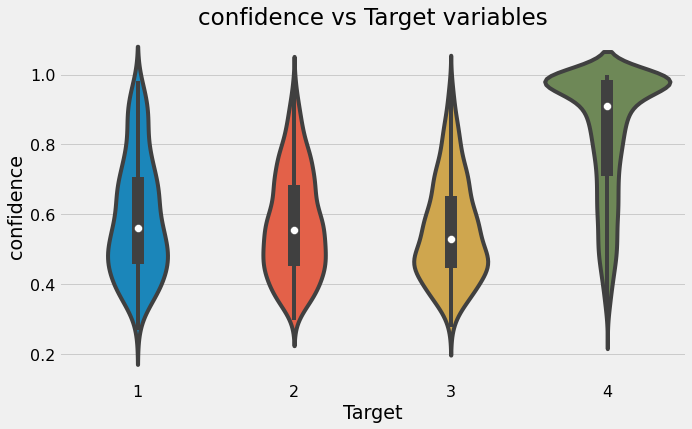

In [58]:
from costa_rican.utils.visualization import BoxByTarget

# Average the predictions over folds
predictions = predictions.groupby('idhogar', as_index = False).mean()

# Find the class and associated probability
predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
predictions = predictions.drop(columns = ['fold'])

# Plot the confidence by each target
BoxByTarget()(x = 'Target', y = 'confidence', data = predictions)

ViolinByTarget()(x = 'Target', y = 'confidence', data = predictions)

In [60]:
%%capture
submission, gbm_fi, valid_scores = model_gbm(train_set, train_labels, 
                                             test_set, test_ids, return_preds=False, submission_base=submission_base)

submission.to_csv('gbm_baseline.csv')

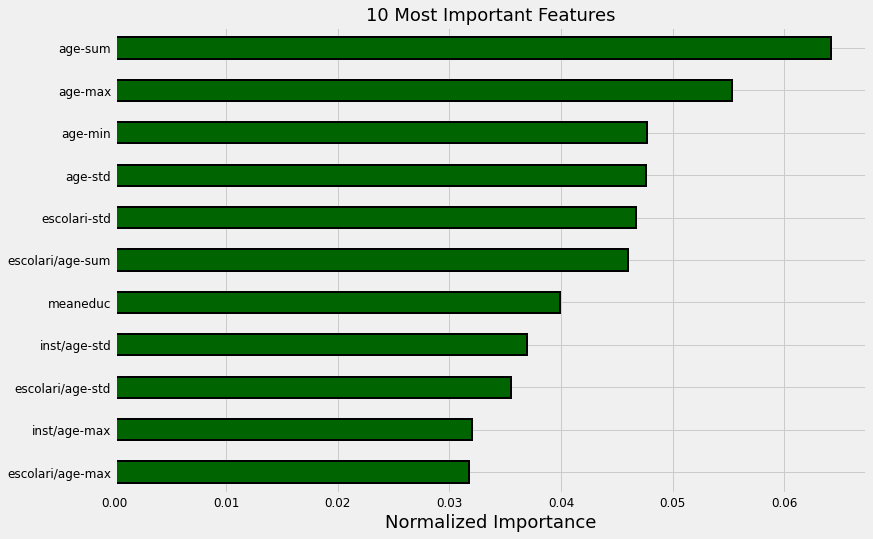

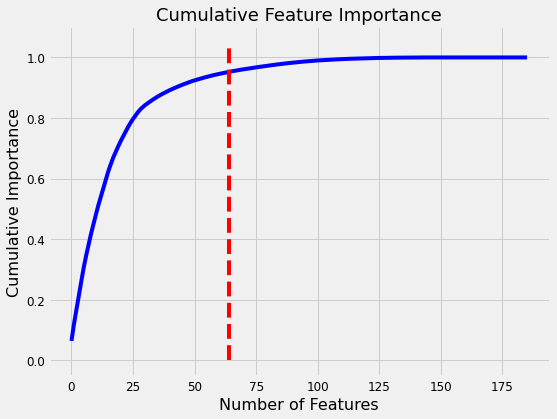

64 features required for 95% of cumulative importance.


In [61]:
_ = plot_feature_importances(gbm_fi, threshold=0.95)

### Try selected features

recursive feature elimination를 통해 구한 인자들을 이용하여 학습해본다.

In [148]:
%%capture --no-display
submission, gbm_fi_selected, valid_scores_selected = model_gbm(train_selected, train_labels, 
                                                               test_selected, test_ids, submission_base=submission_base)

AttributeError: 'LGBMClassifier' object has no attribute 'n_estimators_'

In [65]:
model_results = pd.concat([model_results, pd.DataFrame({'model': ["GBM", "GBM_SEL"], 
                                                   'cv_mean': [valid_scores.mean(), valid_scores_selected.mean()],
                                                   'cv_std':  [valid_scores.std(), valid_scores_selected.std()]})], sort = True, axis=0)

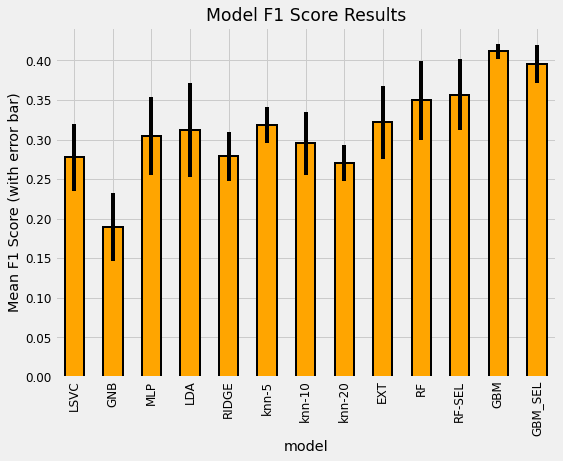

In [66]:
bar_plot_error_bar(model_results)

마지막 단계로 10fold 결과를 추가한다.

In [67]:
%%capture
submission, gbm_fi, valid_scores = model_gbm(train_set, train_labels, test_set, test_ids, 
                                             nfolds=10, return_preds=False, submission_base=submission_base)

In [68]:
%%capture
submission, gbm_fi_selected, valid_scores_selected = model_gbm(train_selected, train_labels, test_selected, test_ids,
                                                               nfolds=10, submission_base=submission_base)

In [69]:
submission.to_csv('gmb_10fold_selected.csv', index = False)

In [70]:
model_results = pd.concat([model_results, pd.DataFrame({'model': ["GBM_10Fold", "GBM_10Fold_SEL"], 
                                                   'cv_mean': [valid_scores.mean(), valid_scores_selected.mean()],
                                                   'cv_std':  [valid_scores.std(), valid_scores_selected.std()]})], sort = True, axis=0)

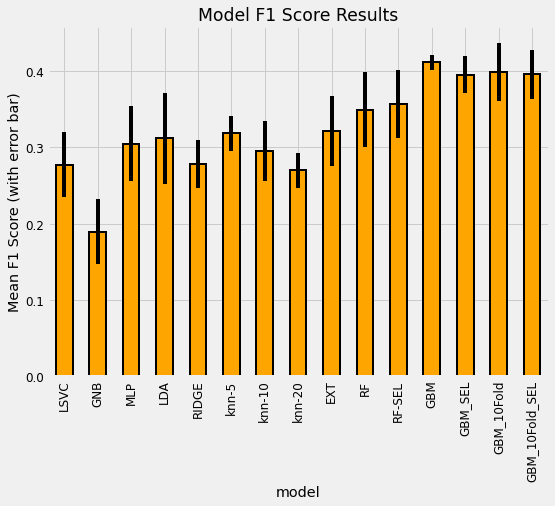

In [74]:
bar_plot_error_bar(model_results)

train_set로 훈련된 GBM모델이 가장 성능이 좋은 것을 확인할 수 있다.

gbm 모델을 이용하여 feature selection을 다시 진행해볼 수 있다.

In [75]:
print(f"There are {gbm_fi_selected[gbm_fi_selected['importance'] == 0].shape[0]} features with no importance.")

There are 0 features with no importance.


In [76]:
gbm_fi_selected

,feature,importance
0,paredblolad,4272.4
1,paredpreb,1182.9
2,pisocemento,2148.6
3,pisomoscer,2358.1
4,cielorazo,906.7
...,...,...
69,inst/age-max,40033.6
70,inst/age-std,42394.4
71,inst/age-range_,21639.9
72,tech-min,365.5


# Model optimization

모델 optimization은 cross-validation을 이용한 hyperparameter tuning을 통해 machine learning 모델의 성능을 최대로 이끌어내는 과정이다.     
모든 데이터 셋에 대해 best한 hyperparameter가 다를 수 있으므로 이는 매우 중요한 과정이다.

크게 아래 네가지 방법이 존재한다.
1. manual
2. grid search
3. random search
4. Automated optimization
   
이번 노트북에서는 4에 집중한다.

# Model tuning with hyperopt

베이지안 최적화 과정은 4가지가 요구된다.
1. 목적 함수: 최대 or 최소화 하려는 함수
2. 탐색할 범위
3. 다음 hyperparmeter를 선택하기 위한 알고리즘: 다음 값을 제안하기 위해 과거의 값 사용
4. Results history: 과거 결과를 저장.

In [96]:
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK
from hyperopt.pyll.stochastic import sample
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

In [ ]:
import csv
import ast
from timeit import default_timer as timer

## 1. Objective function

model hyperparameter를 받고 관련한 validation score를 반환하는 함수를 작성.     
hyperopt는 값을 최소화 하므로 1 - Macro F1 score를 반환한다.

In [138]:
def objective(hyperparameters, nfolds=5):
    """Return validation score from hyperparameters for LightGBM"""
    
    # Keep track of evals
    global ITERATION
    ITERATION += 1
    
    # Retrieve the subsample
    subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    subsample_freq = hyperparameters['boosting_type'].get('subsample_freq', 0)
    
    boosting_type = hyperparameters['boosting_type']['boosting_type']
    
    if boosting_type == 'dart':
        hyperparameters['drop_rate'] = hyperparameters['boosting_type']['drop_rate']
    
    # Subsample and subsample frequency to top level keys
    hyperparameters['subsample'] = subsample
    hyperparameters['subsample_freq'] = subsample_freq
    hyperparameters['boosting_type'] = boosting_type
    
    # Whether or not to use limit maximum depth
    if not hyperparameters['limit_max_depth']:
        hyperparameters['max_depth'] = -1
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['max_depth', 'num_leaves', 'subsample_for_bin', 
                           'min_child_samples', 'subsample_freq']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True)
    
    # Convert to arrays for indexing
    features = np.array(train_selected)
    labels = np.array(train_labels).reshape((-1 ))
    
    valid_scores = []
    # best_estimators = []
    run_times = []
    
    model = lgb.LGBMClassifier(**hyperparameters, class_weight = 'balanced',
                               n_jobs=-1, metric = 'None',
                               n_estimators=10000)
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        start = timer()
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds = 100, 
                  eval_metric = macro_f1_score, 
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 400)
        end = timer()
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        # best_estimators.append(model.best_iteration_)
        
        run_times.append(end - start)
    
    score = np.mean(valid_scores)
    score_std = np.std(valid_scores)
    loss = 1 - score
    
    run_time = np.mean(run_times)
    run_time_std = np.std(run_times)
    
    # estimators = int(np.mean(best_estimators))
    # hyperparameters['n_estimators'] = estimators
    
    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, score, score_std])
    of_connection.close()
    
    # Display progress
    if ITERATION % PROGRESS == 0:
        display(f'Iteration: {ITERATION}, Current Score: {round(score, 4)}.')
    
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'time': run_time, 'time_std': run_time_std, 'status': STATUS_OK, 
            'score': score, 'score_std': score_std}

## 2. Search space

도메인은 우리가 탐색하고 싶은 범위를 나타낸다. 주의해야 할 부분은 boosting_type='goss' 일 때 subsample 값이 1이어야 한다는 것이다.

In [132]:
# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', 
                              [{'boosting_type': 'gbdt', 
                                'subsample': hp.uniform('gdbt_subsample', 0.5, 1),
                                'subsample_freq': hp.quniform('gbdt_subsample_freq', 1, 10, 1)}, 
                               {'boosting_type': 'dart', 
                                 'subsample': hp.uniform('dart_subsample', 0.5, 1),
                                 'subsample_freq': hp.quniform('dart_subsample_freq', 1, 10, 1),
                                 'drop_rate': hp.uniform('dart_drop_rate', 0.1, 0.5)},
                                {'boosting_type': 'goss',
                                 'subsample': 1.0,
                                 'subsample_freq': 0}]),
    'limit_max_depth': hp.choice('limit_max_depth', [True, False]),
    'max_depth': hp.quniform('max_depth', 1, 40, 1),
    'num_leaves': hp.quniform('num_leaves', 3, 50, 1),
    'learning_rate': hp.loguniform('learning_rate', 
                                   np.log(0.025), 
                                   np.log(0.25)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 2000, 100000, 2000),
    'min_child_samples': hp.quniform('min_child_samples', 5, 80, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.5, 1.0)
}

In [133]:
sample(space)

{'boosting_type': {'boosting_type': 'gbdt',
  'subsample': 0.8711243175056285,
  'subsample_freq': 2.0},
 'colsample_bytree': 0.8246145711539007,
 'learning_rate': 0.13615166620553246,
 'limit_max_depth': True,
 'max_depth': 25.0,
 'min_child_samples': 5.0,
 'num_leaves': 9.0,
 'reg_alpha': 0.7544957209636038,
 'reg_lambda': 0.8141133067068674,
 'subsample_for_bin': 2000.0}

## 3. Algorithm

The algorithm for choosing the next values is the Tree Parzen Estimator which uses Bayes rule for constructing a surrogate model of the objective function. Instead of maximizing the objective function, the algorithm maximizes the Expected Improvement (EI) of the surrogate model.

Tree parzen esitmator 알아보기

In [134]:
algo = tpe.suggest

## 4. Results history

결과를 기록하기 위해 두가지 방법을 이용한다.
1. Trials object: 목적함수로부터 반환받는 모든 것을 기록
2. csv파일에 매 iteration 마다 기록

한가지 방법이 정상적으로 작동하지 않을 경우를 대비하여 결과를 추적하기 위한 여러 방법을 사용한다.

In [135]:
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK
from hyperopt.pyll.stochastic import sample

import csv
import ast
from timeit import default_timer as timer

In [136]:
# Record results
trials = Trials()

# Create a file and open a connection
OUT_FILE = 'optimization.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

MAX_EVALS = 100
PROGRESS = 10
N_FOLDS = 5
ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score', 'std']
writer.writerow(headers)
of_connection.close()

In [139]:
%%capture --no-display
display("Running Optimization for {} Trials.".format(MAX_EVALS))

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)

'Running Optimization for 100 Trials.'

'Iteration: 10, Current Score: 0.3919.'

'Iteration: 20, Current Score: 0.3839.'

'Iteration: 30, Current Score: 0.4356.'

'Iteration: 40, Current Score: 0.4388.'

'Iteration: 50, Current Score: 0.3857.'

'Iteration: 60, Current Score: 0.4378.'

'Iteration: 70, Current Score: 0.4373.'

'Iteration: 80, Current Score: 0.4366.'

'Iteration: 90, Current Score: 0.4373.'

'Iteration: 100, Current Score: 0.4268.'

In [ ]:
import json

# Save the trial results
with open('trials.json', 'w') as f:
    f.write(json.dumps(str(trials)))

# Using Optimized Model

In [140]:
results = pd.read_csv(OUT_FILE).sort_values('loss', ascending = True).reset_index()
results.head()

,index,loss,hyperparameters,iteration,runtime,score,std
0,23,0.549127,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",25,1.059416,0.450873,0.007330
1,57,0.553602,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",59,1.435975,0.446398,0.024292
2,13,0.554593,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",15,1.281477,0.445407,0.015855
3,21,0.554706,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",23,1.109465,0.445294,0.016578
4,97,0.554743,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",99,0.976700,0.445257,0.017824


/home/skang/Documents/Costa_Rican_Household_Poverty_Level_Prediction/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


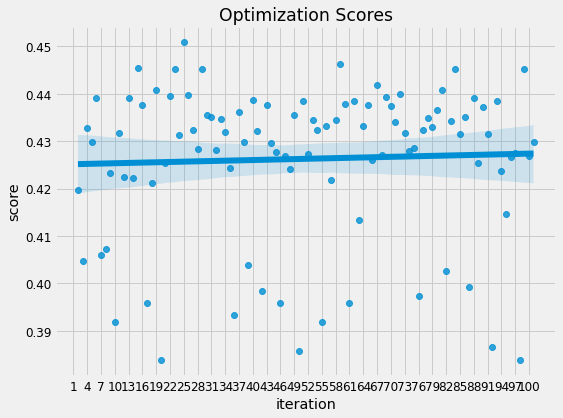

In [141]:
plt.figure(figsize = (8, 6))
sns.regplot('iteration', 'score', data = results)
plt.title("Optimization Scores")
plt.xticks(list(range(1, results['iteration'].max() + 1, 3)))

In [142]:
best_hyp = ast.literal_eval(results.loc[0, 'hyperparameters'])
best_hyp

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.7571898748494308,
 'learning_rate': 0.02564390894721063,
 'limit_max_depth': False,
 'max_depth': -1,
 'min_child_samples': 30,
 'num_leaves': 26,
 'reg_alpha': 0.10298580003302146,
 'reg_lambda': 0.13740005325154542,
 'subsample_for_bin': 80000,
 'subsample': 0.6987081036676847,
 'subsample_freq': 3}

In [195]:
submission, gbm_fi, valid_scores = model_gbm(train_selected, train_labels, 
                                             test_selected, test_ids, 
                                             nfolds = 10, return_preds=False, submission_base=submission_base, hyp=best_hyp)

[LightGBM] [Warning] Unknown parameter: limit_max_depth


/home/skang/Documents/Costa_Rican_Household_Poverty_Level_Prediction/costa_rican/utils/evaluation.py:151: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(fold_predictions)


'Fold 1, Validation Score: 0.40037, Estimators Trained: 85'

[LightGBM] [Warning] Unknown parameter: limit_max_depth
[200]	train's multi_logloss: 0.3187	train's macro_f1: 0.912945	valid's multi_logloss: 0.789285	valid's macro_f1: 0.447224


/home/skang/Documents/Costa_Rican_Household_Poverty_Level_Prediction/costa_rican/utils/evaluation.py:151: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(fold_predictions)


'Fold 2, Validation Score: 0.43947, Estimators Trained: 103'

[LightGBM] [Warning] Unknown parameter: limit_max_depth


/home/skang/Documents/Costa_Rican_Household_Poverty_Level_Prediction/costa_rican/utils/evaluation.py:151: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(fold_predictions)


'Fold 3, Validation Score: 0.38945, Estimators Trained: 70'

[LightGBM] [Warning] Unknown parameter: limit_max_depth


/home/skang/Documents/Costa_Rican_Household_Poverty_Level_Prediction/costa_rican/utils/evaluation.py:151: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(fold_predictions)


'Fold 4, Validation Score: 0.29786, Estimators Trained: 50'

[LightGBM] [Warning] Unknown parameter: limit_max_depth


/home/skang/Documents/Costa_Rican_Household_Poverty_Level_Prediction/costa_rican/utils/evaluation.py:151: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(fold_predictions)


'Fold 5, Validation Score: 0.40956, Estimators Trained: 83'

[LightGBM] [Warning] Unknown parameter: limit_max_depth


/home/skang/Documents/Costa_Rican_Household_Poverty_Level_Prediction/costa_rican/utils/evaluation.py:151: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(fold_predictions)


'Fold 6, Validation Score: 0.31143, Estimators Trained: 73'

[LightGBM] [Warning] Unknown parameter: limit_max_depth


/home/skang/Documents/Costa_Rican_Household_Poverty_Level_Prediction/costa_rican/utils/evaluation.py:151: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(fold_predictions)


'Fold 7, Validation Score: 0.36474, Estimators Trained: 87'

[LightGBM] [Warning] Unknown parameter: limit_max_depth
[200]	train's multi_logloss: 0.314265	train's macro_f1: 0.916747	valid's multi_logloss: 0.832557	valid's macro_f1: 0.393069


/home/skang/Documents/Costa_Rican_Household_Poverty_Level_Prediction/costa_rican/utils/evaluation.py:151: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(fold_predictions)


'Fold 8, Validation Score: 0.38958, Estimators Trained: 105'

[LightGBM] [Warning] Unknown parameter: limit_max_depth
[200]	train's multi_logloss: 0.317356	train's macro_f1: 0.906093	valid's multi_logloss: 0.809266	valid's macro_f1: 0.38748


/home/skang/Documents/Costa_Rican_Household_Poverty_Level_Prediction/costa_rican/utils/evaluation.py:151: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(fold_predictions)


'Fold 9, Validation Score: 0.42096, Estimators Trained: 111'

[LightGBM] [Warning] Unknown parameter: limit_max_depth


/home/skang/Documents/Costa_Rican_Household_Poverty_Level_Prediction/costa_rican/utils/evaluation.py:151: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(fold_predictions)


'Fold 10, Validation Score: 0.34875, Estimators Trained: 60'

'10 cross validation score: 0.37722 with std: 0.04389.'

In [152]:
%%capture
submission, gbm_fi, valid_scores = model_gbm(train_selected, train_labels, 
                                             test_selected, test_ids, 
                                             nfolds = 10, return_preds=False, submission_base=submission_base, hyp=best_hyp)

model_results = model_results.append(pd.DataFrame({'model': ["GBM_OPT_10Fold_SEL"], 
                                                   'cv_mean': [valid_scores.mean()],
                                                   'cv_std':  [valid_scores.std()]}),
                                    sort = True).sort_values('cv_mean', ascending = False)

In [153]:
%%capture
submission, gbm_fi, valid_scores = model_gbm(train_set, train_labels, 
                                             test_set, test_ids, 
                                             nfolds = 10, return_preds=False, submission_base=submission_base, hyp=best_hyp)

model_results = model_results.append(pd.DataFrame({'model': ["GBM_OPT_10Fold"], 
                                                   'cv_mean': [valid_scores.mean()],
                                                   'cv_std':  [valid_scores.std()]}),
                                    sort = True).sort_values('cv_mean', ascending = False)

In [154]:
model_results.head()

,cv_mean,cv_std,index,model
11,0.41161,0.00954,NaN,GBM
13,0.398852,0.038326,NaN,GBM_10Fold
14,0.39599,0.032397,NaN,GBM_10Fold_SEL
12,0.3953,0.024184,NaN,GBM_SEL
0,0.379532,0.043769,NaN,GBM_OPT_10Fold_SEL


In [155]:
submission.to_csv('gbm_opt_10fold_selected.csv', index = False)

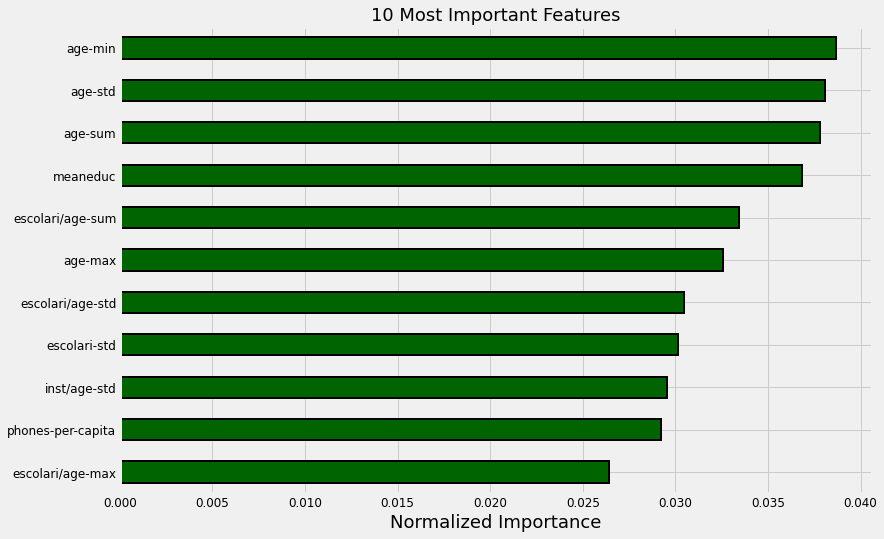

In [156]:
_ = plot_feature_importances(gbm_fi)

# Investigate predictions

모델을 들여다보는 첫 단계에서, test 데이터에 대한 예측 결과를 시각화 할 수 있다.     
여기서 우리는 예측 결과의 분포가 training data의 분포와 유사할 것이라고 예상해볼 수 있다.     
샘플의 숫자가 다르기 때문에 normalized한 결과를 시각화한다.

In [159]:
heads = train.loc[train['parentesco1'] == 1].copy()

In [161]:
from collections import OrderedDict

In [162]:
poverty_mapping = OrderedDict(
            {1: "extreme", 2: "moderate", 3: "vulnerable", 4: "non vulerable"}
        )

Text(0.5, 1.0, 'Predicted Label Distribution')

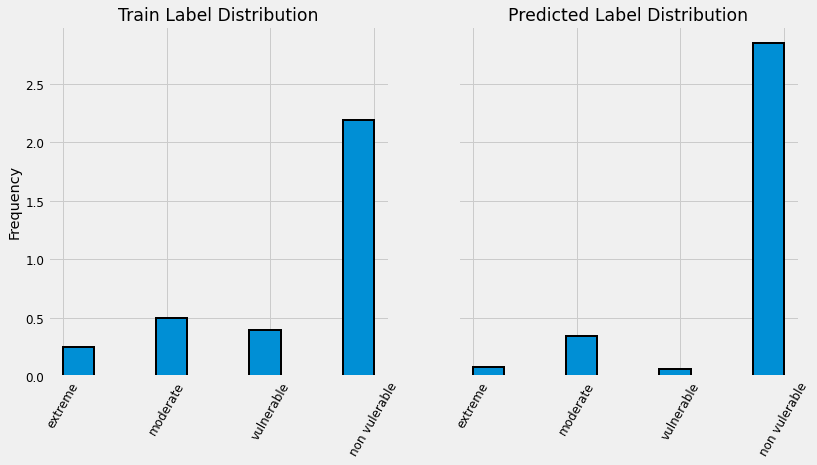

In [164]:
preds = submission_base.merge(submission, on = 'Id', how = 'left')
preds = pd.DataFrame(preds.groupby('idhogar')['Target'].mean())

# Plot the training labels distribution
fig, axes = plt.subplots(1, 2, sharey = True, figsize = (12, 6))
heads['Target'].sort_index().plot.hist(density = True,
                                       edgecolor = r'k',
                                       linewidth = 2,
                                       ax = axes[0])

axes[0].set_xticks([1, 2, 3, 4]);
axes[0].set_xticklabels(poverty_mapping.values(), rotation = 60)
axes[0].set_title('Train Label Distribution')

# Plot the predicted labels
preds['Target'].sort_index().plot.hist(density = True, 
                                       edgecolor = 'k',
                                       linewidth = 2,
                                       ax = axes[1])
axes[1].set_xticks([1, 2, 3, 4]);
axes[1].set_xticklabels(poverty_mapping.values(), rotation = 60)
plt.subplots_adjust()
plt.title('Predicted Label Distribution')

In [165]:
heads['Target'].value_counts()

4    1954
2     442
3     355
1     222
Name: Target, dtype: int64

In [166]:
preds['Target'].value_counts()

4.0    6289
2.0     752
1.0     170
3.0     141
Name: Target, dtype: int64

# Validation

In [167]:
from sklearn.model_selection import train_test_split

# Split into validation set
X_train, X_valid, y_train, y_valid = train_test_split(train_selected,
                                                      train_labels,
                                                      test_size = 1000,
                                                      random_state = 10)

# Create model and train
model = lgb.LGBMClassifier(**best_hyp, 
                           class_weight = 'balanced',
                           random_state = 10)
model.fit(X_train, y_train);

[LightGBM] [Warning] Unknown parameter: limit_max_depth


In [168]:
# Make validation predictions
valid_preds = model.predict_proba(X_valid)
preds_df = pd.DataFrame(valid_preds, columns = [1, 2, 3, 4])

# Convert into predictions
preds_df['prediction'] = preds_df[[1, 2, 3, 4]].idxmax(axis = 1)
preds_df['confidence'] = preds_df[[1, 2, 3, 4]].max(axis = 1)

preds_df.head()

,1,2,3,4,prediction,confidence
0,0.039302,0.036619,0.042577,0.881502,4,0.881502
1,0.025944,0.021558,0.012575,0.939923,4,0.939923
2,0.037953,0.105380,0.394093,0.462573,4,0.462573
3,0.197731,0.441840,0.282860,0.077569,2,0.441840
4,0.035220,0.205797,0.653902,0.105081,3,0.653902


In [169]:
print('F1 score:', round(f1_score(y_valid, preds_df['prediction'], average = 'macro'), 5))

F1 score: 0.43327


In [170]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[ 27  25  10  18]
 [ 25  53  28  33]
 [ 10  29  36  38]
 [ 27  54  86 501]]


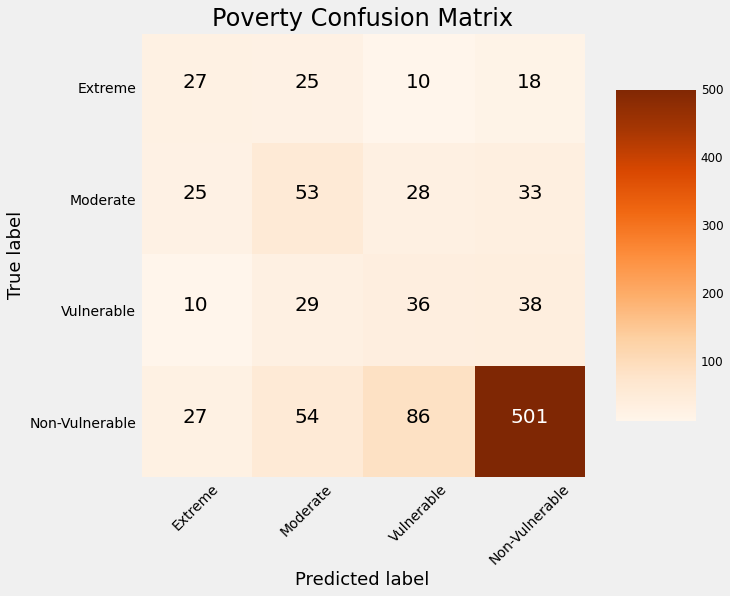

In [171]:
cm = confusion_matrix(y_valid, preds_df['prediction'])

plot_confusion_matrix(cm, classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = 'Poverty Confusion Matrix')

Normalized confusion matrix
[[0.3375     0.3125     0.125      0.225     ]
 [0.17985612 0.38129496 0.20143885 0.23741007]
 [0.08849558 0.25663717 0.31858407 0.33628319]
 [0.04041916 0.08083832 0.12874251 0.75      ]]


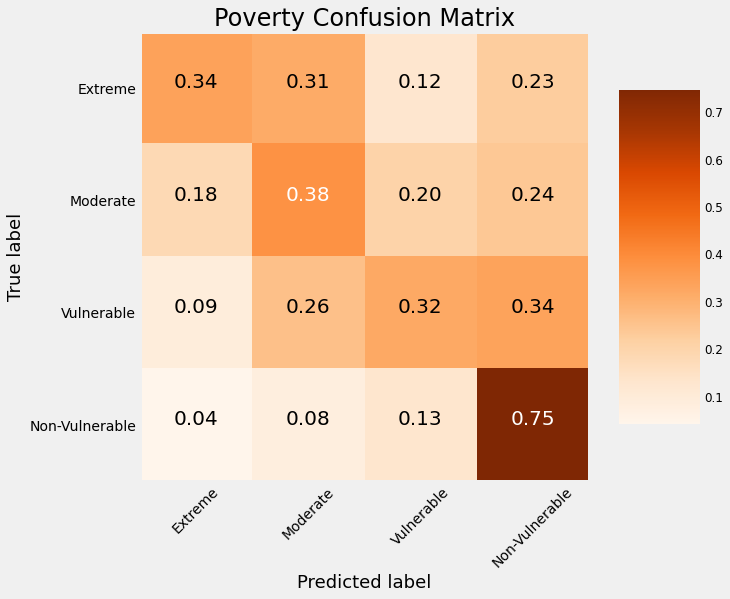

In [172]:
plot_confusion_matrix(cm, normalize = True,
                      classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = 'Poverty Confusion Matrix')

oversampling 또는 다른 data sections별로 모델을 학습하는 방법이 있지만 가장 좋은 방법은 데이터를 더 모으는 것이다.

# Dimension reduction

마지막 section으로 차원축소에 대해 다룬다.      
4가지 방법을 다뤄본다.      

1. PCA: Principal Components Analysis. Finds the dimensions of greatest variation in the data     
2. ICA: Independent Components Analysis. Attempts to separate a mutltivariate signal into independent signals.      
3. TSNE: T-distributed Stochastic Neighbor Embedding. Maps high-dimensional data to a low-dimensional manifold attempting to maintain the local structure within the data. It is a non-linear technique and generally only used for visualization.      
4. UMAP: Uniform Manifold Approximation and Projection: A relatively new technique that also maps data to a low-dimensional manifold but tries to preserve more global structure than TSNE.      

In [184]:
from umap import UMAP
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE

n_components = 3

umap = UMAP(n_components=n_components)
pca = PCA(n_components=n_components)
ica = FastICA(n_components=n_components)
tsne = TSNE(n_components=n_components)

/home/skang/Documents/Costa_Rican_Household_Poverty_Level_Prediction/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [185]:
train_df = train_selected.copy()
test_df = test_selected.copy()

for method, name in zip([umap, pca, ica, tsne], 
                        ['umap', 'pca', 'ica', 'tsne']):
    
    # TSNE has no transform method
    if name == 'tsne':
        start = timer()
        reduction = method.fit_transform(train_selected)
        end = timer()
    
    else:
        start = timer()
        reduction = method.fit_transform(train_selected)
        end = timer()
        
        test_reduction = method.transform(test_selected)
    
        # Add components to test data
        test_df['%s_c1' % name] = test_reduction[:, 0]
        test_df['%s_c2' % name] = test_reduction[:, 1]
        test_df['%s_c3' % name] = test_reduction[:, 2]

    # Add components to training data for visualization and modeling
    train_df['%s_c1' % name] = reduction[:, 0]
    train_df['%s_c2' % name] = reduction[:, 1]
    train_df['%s_c3' % name] = reduction[:, 2]
    
    print(f'Method: {name} {round(end - start, 2)} seconds elapsed.')

Method: umap 10.07 seconds elapsed.
Method: pca 0.04 seconds elapsed.
Method: ica 0.08 seconds elapsed.


/home/skang/Documents/Costa_Rican_Household_Poverty_Level_Prediction/venv/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(
/home/skang/Documents/Costa_Rican_Household_Poverty_Level_Prediction/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/skang/Documents/Costa_Rican_Household_Poverty_Level_Prediction/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Method: tsne 14.92 seconds elapsed.


In [186]:
from mpl_toolkits.mplot3d import Axes3D

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map
    Source: https://gist.github.com/jakevdp/91077b0cae40f8f8244a"""

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

cmap = discrete_cmap(4, base_cmap = plt.cm.RdYlBu)

train_df['label'] = train_labels

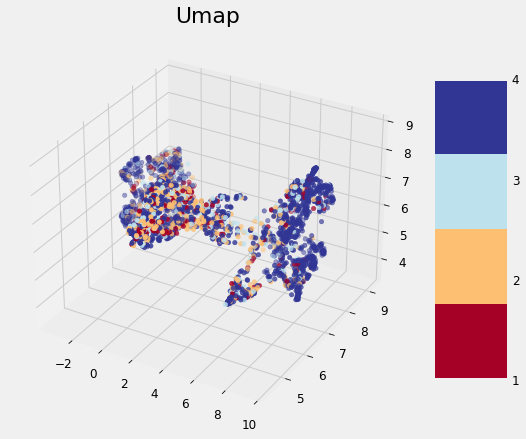

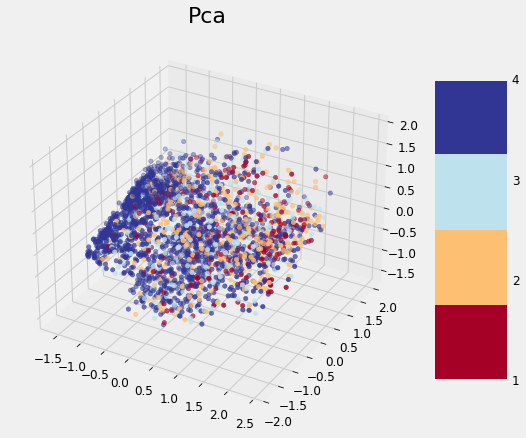

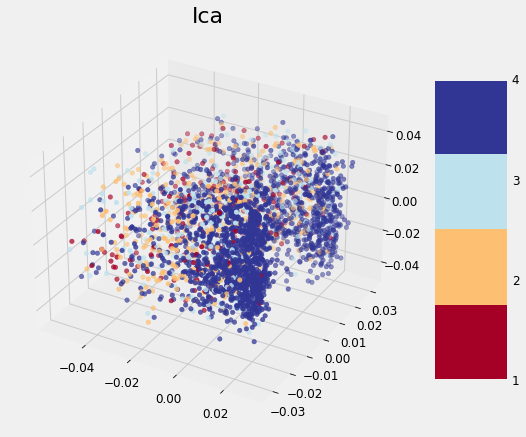

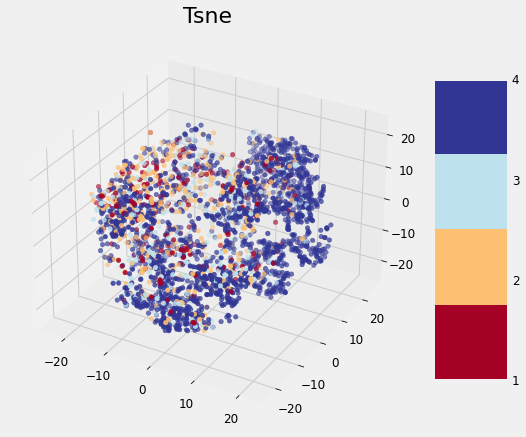

In [187]:
# Plot each method
for method, name in zip([umap, pca, ica, tsne], 
                        ['umap', 'pca', 'ica', 'tsne']):
    
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    p = ax.scatter(train_df['%s_c1' % name], train_df['%s_c2'  % name], train_df['%s_c3'  % name], 
                   c = train_df['label'].astype(int), cmap = cmap)
    
    plt.title(f'{name.capitalize()}', size = 22)
    fig.colorbar(p, aspect = 4, ticks = [1, 2, 3, 4])

In [188]:
train_df, test_df = train_df.align(test_df, axis = 1, join = 'inner')

In [191]:
%%capture

submission, gbm_fi, valid_scores = model_gbm(train_df, train_labels, 
                                             test_df, test_ids, nfolds = 10,
                                             hyp = best_hyp,
                                             submission_base=submission_base)

In [192]:
submission.to_csv('gbm_opt_10fold_dr.csv', index = False)

In [193]:
model_results = model_results.append(pd.DataFrame({'model': ["GBM_OPT_10Fold_DR"], 
                                                   'cv_mean': [valid_scores.mean()],
                                                   'cv_std':  [valid_scores.std()]}),
                                    sort = True)

/tmp/ipykernel_3975785/1689181589.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_results = model_results.append(pd.DataFrame({'model': ["GBM_OPT_10Fold_DR"],


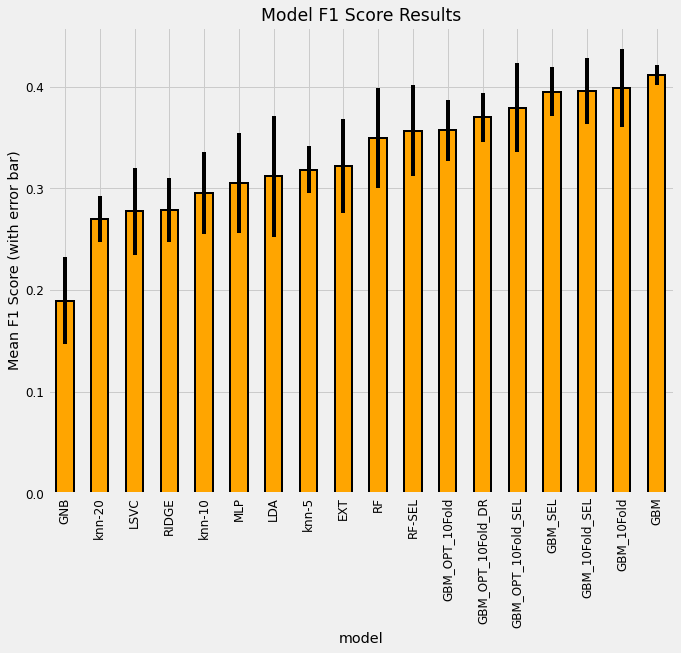

In [194]:
model_results = model_results.sort_values('cv_mean')
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (10, 8),
                                  edgecolor = 'k', linewidth = 2,
                                  yerr = list(model_results['cv_std']))
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');
model_results.reset_index(inplace = True)

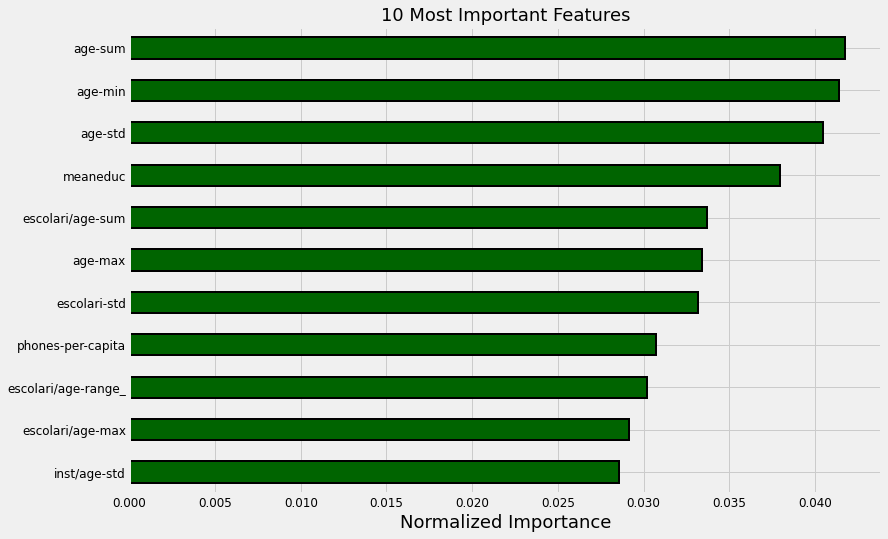

In [196]:
_ = plot_feature_importances(gbm_fi)

# Visualize single decision tree

In [197]:
model = RandomForestClassifier(max_depth = 3, n_estimators=10)
model.fit(train_selected, train_labels)
estimator_limited = model.estimators_[5]
estimator_limited

DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                       random_state=1092992064)

In [198]:
from sklearn.tree import export_graphviz

export_graphviz(estimator_limited, out_file='tree_limited.dot', feature_names = train_selected.columns,
                class_names = ['extreme', 'moderate' , 'vulnerable', 'non-vulnerable'],
                rounded = True, proportion = False, precision = 2, filled = True)

In [ ]:
!dot -Tpng tree_limited.dot -o tree_limited.png

In [ ]:
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree_limited.png')